In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["pdf.fonttype"] = 42 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc.settings.set_figure_params(dpi=120)
sns.set_style("dark")

In [3]:
from sklearn.svm import SVR

def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected

In [4]:
adata = sc.read_10x_mtx("3D EB protocol D14/", cache=True)

In [5]:
adata

AnnData object with n_obs × n_vars = 1437 × 36601
    var: 'gene_ids', 'feature_types'

In [6]:
adata.obs['n_counts'] = adata.X.sum(axis=1)

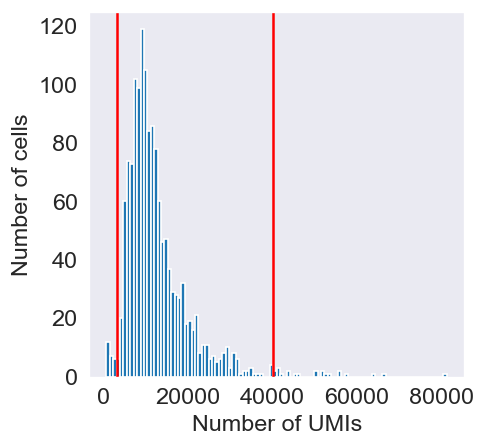

In [7]:
n, bins, *x = plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Number of UMIs")
plt.ylabel("Number of cells")
plt.axvline(3000, c="r")
plt.axvline(40000, c="r")
plt.show()

In [8]:
sc.pp.filter_cells(adata, min_counts=3000)
sc.pp.filter_cells(adata, max_counts=40000)

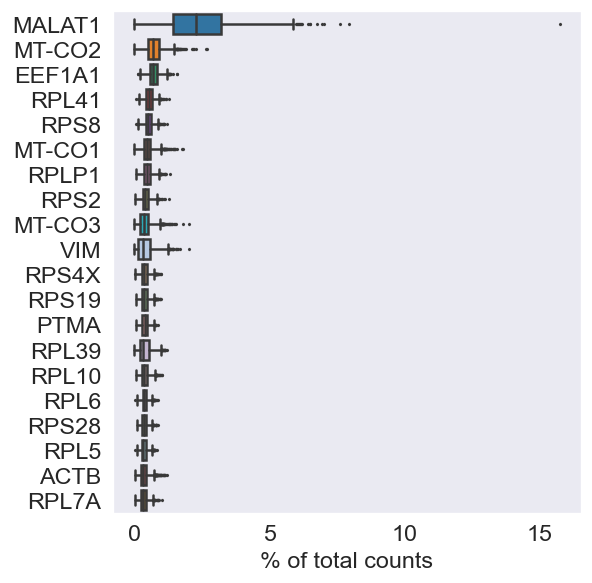

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [10]:
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes
len(expressed_genes)

1389

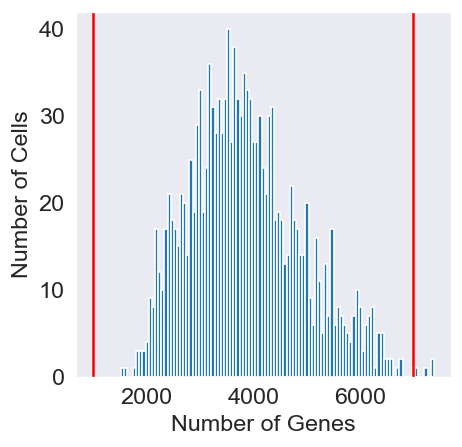

In [11]:
n, bins, *x = plt.hist(expressed_genes, bins=100)
plt.axvline(1000, c="r")
plt.axvline(7000, c="r")
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

In [12]:
adata = adata[adata.obs['n_genes'] > 1000, :].copy()
adata = adata[adata.obs['n_genes'] < 7000, :].copy()

In [13]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = adata.X.sum(axis=1)

... storing 'feature_types' as categorical


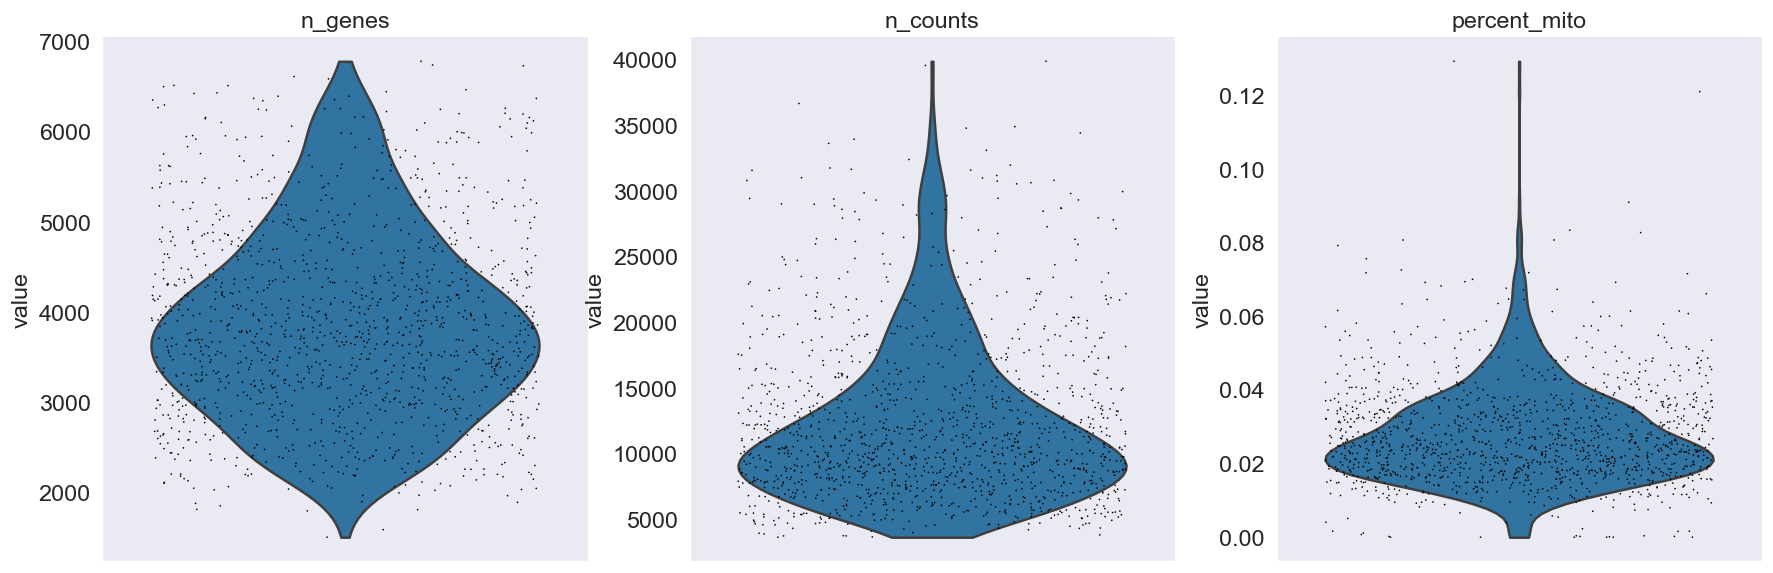

In [14]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

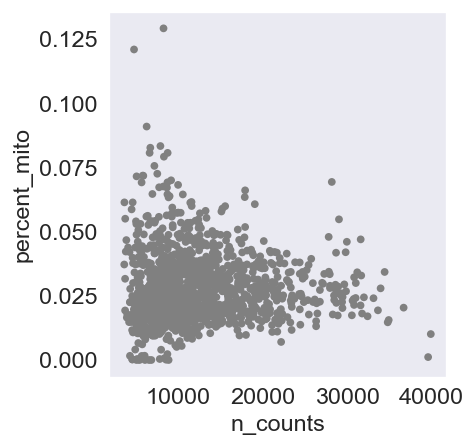

In [15]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

In [16]:
adata = adata[adata.obs['percent_mito'] < 0.10].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
adata_raw = adata.copy()

In [18]:
adata

AnnData object with n_obs × n_vars = 1382 × 36601
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_ids', 'feature_types'

In [19]:
sc.pp.filter_genes(adata, min_cells=20)

In [20]:
sc.pp.normalize_total(adata)

In [21]:
adata.raw = adata

In [22]:
S_genes_hum = ["MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", 
            "MCM6", "CDCA7", "DTL", "PRIM1", "UHRF1", "CENPU", "HELLS", "RFC2", 
            "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", 
            "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", 
            "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"]
G2M_genes_hum = ["HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
             "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "PIMREG", 
             "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", 
             "TUBB4B", "GTSE1", "KIF20B", "HJURP", "CDCA3", "JPT1", "CDC20", "TTK",
             "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2", 
             "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", 
             "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"]
sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_hum, g2m_genes=G2M_genes_hum)

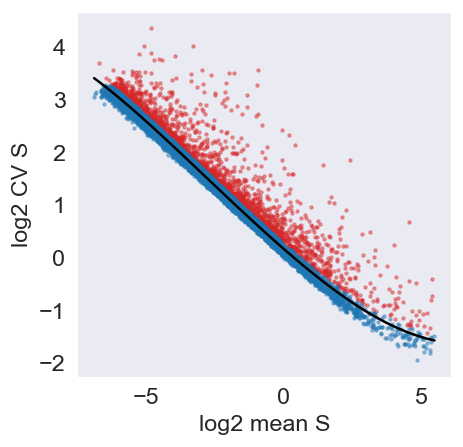

In [23]:
cv_vs_mean_keep = filter_cv_vs_mean(adata.X.toarray().T, N=2000, max_expr_avg=50)

In [24]:
sc.pp.log1p(adata)

In [25]:
adata = adata[:, cv_vs_mean_keep].copy()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [26]:
sc.pp.regress_out(adata, ['S_score'])

... storing 'phase' as categorical


In [27]:
sc.pp.regress_out(adata, ['G2M_score'])

In [28]:
sc.pp.scale(adata, max_value=10)

In [29]:
sc.tl.pca(adata, svd_solver='arpack')

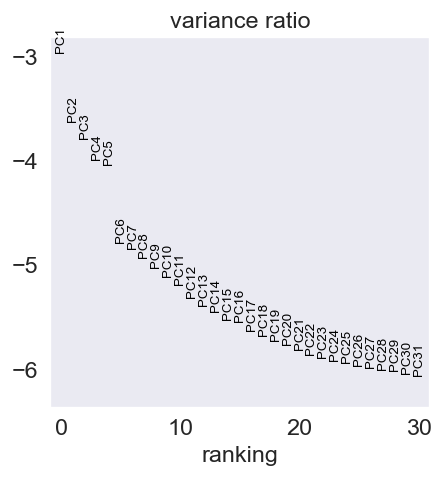

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

In [31]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=20)

In [32]:
sc.tl.umap(adata, alpha=0.3, min_dist=0.5, random_state=0)

In [33]:
sc.tl.louvain(adata, resolution=1)

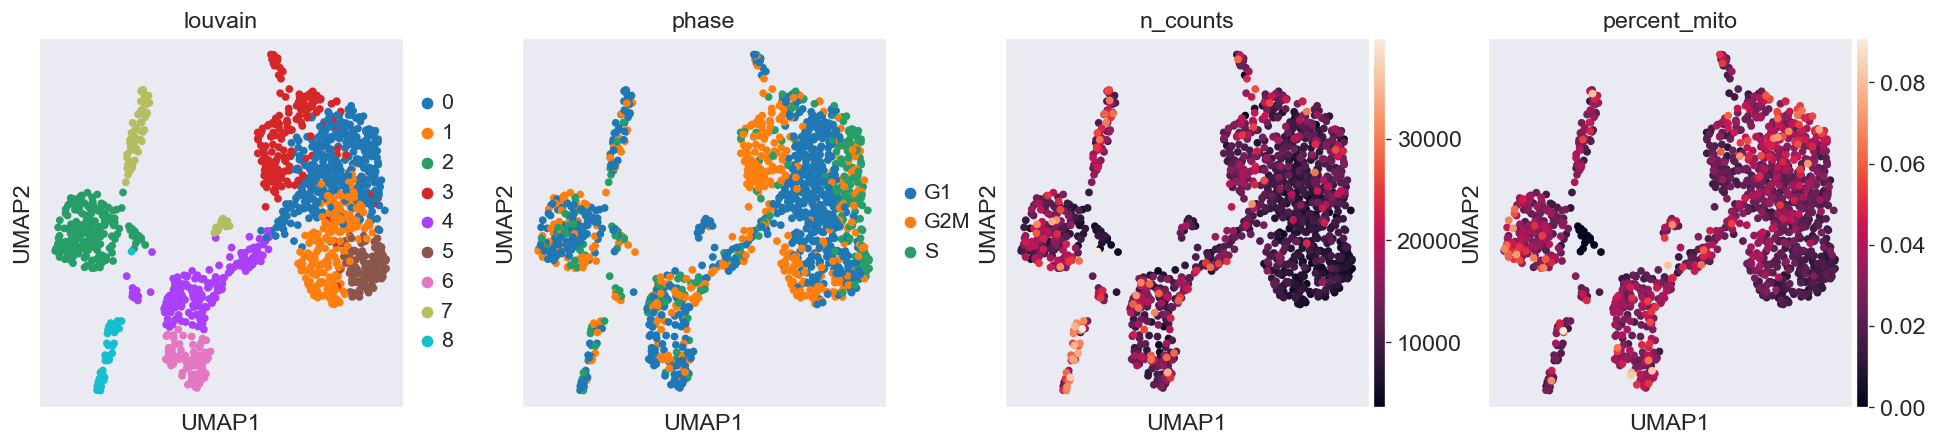

In [34]:
sc.pl.umap(adata, use_raw=True, color=['louvain', "phase", 'n_counts', 'percent_mito'], ncols=4)

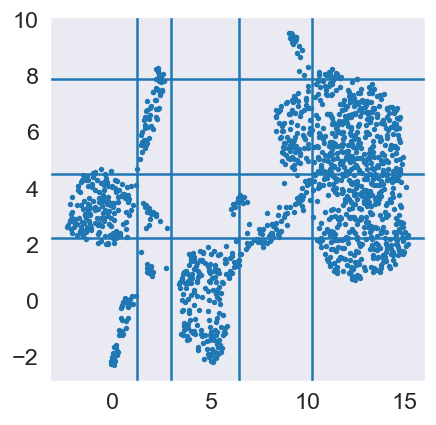

In [35]:
plt.scatter(adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1], s=5)
plt.axhline(4.5)
plt.axhline(7.9)
plt.axvline(10.25)
plt.axvline(1.25)
plt.axhline(2.25)
plt.axvline(6.5)
plt.axvline(3)

In [36]:
nl = []
for i,x,y in zip(adata.obs["louvain"], adata.obsm["X_umap"][:, 0], adata.obsm["X_umap"][:, 1]):
    if i=="7" and y<4.5:
        nl.append("9")
    elif i=="4" and x<3:
        nl.append("10")
    elif i=="3" and x<10.25 and y>7.9:
        nl.append("11")
    elif i=="2" and x>1.25 and y<4:
        nl.append("12")
    elif i=="4" and y<2.25 and x<6.5:
        nl.append("13")
    else: nl.append(i)
adata.obs['louvain'] = nl

... storing 'louvain' as categorical


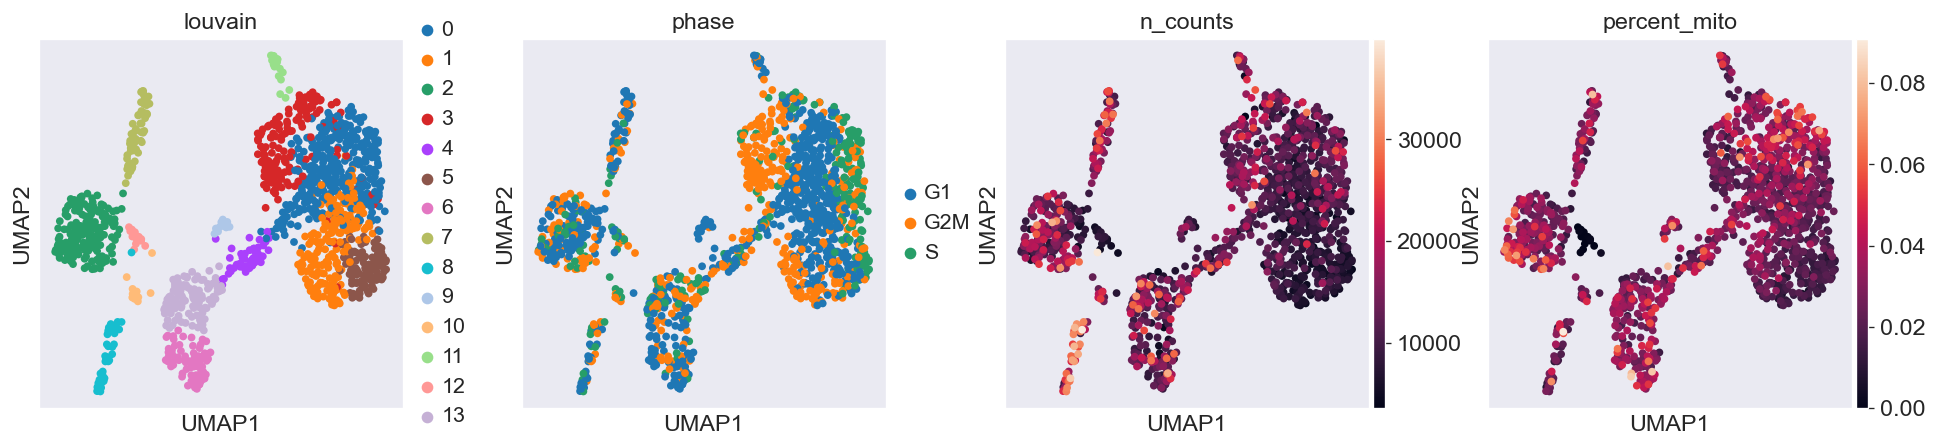

In [37]:
sc.pl.umap(adata, use_raw=True, color=['louvain', "phase", 'n_counts', 'percent_mito'], ncols=4)

In [38]:
adata_raw.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw.obs["louvain"] = adata.obs["louvain"]

In [39]:
adata_raw_norm = adata_raw.copy()
sc.pp.normalize_total(adata_raw_norm)
sc.pp.log1p(adata_raw_norm)

In [40]:
louvain2type = {'0': "Prosencephalon (Forebrain)", 
                '1': "Prosencephalon (Forebrain)", 
                '10': "Hox-rich organizer", 
                '11': "RetProg", 
                '12': "Low Quality Cells", 
                '13': "Rhombencephalon (Hindbrain)", 
                '2': "Schwann cell precursors", 
                '3': "Prosencephalon (Forebrain)", 
                '4': "Mesencephalon (Midbrain)", 
                '5': "Prosencephalon (Forebrain)", 
                '6': "Posterior Roof Plate", 
                '7': "Neuroblasts 1", 
                '8': "Mesenchyme", 
                '9': "Neuroblasts 2"}

In [41]:
adata_raw.obs["cell_type"] = [louvain2type[i] for i in adata_raw.obs["louvain"]]
adata.obs["cell_type"] = [louvain2type[i] for i in adata.obs["louvain"]]
adata_raw_norm.obs["cell_type"] = [louvain2type[i] for i in adata_raw_norm.obs["louvain"]]

... storing 'cell_type' as categorical


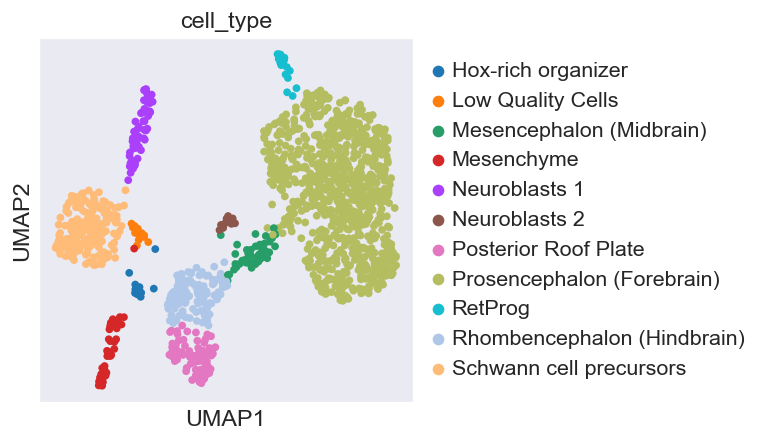

In [42]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["cell_type"], ncols=5)

In [43]:
adata_raw_norm.obs["cell_type"].value_counts()/adata_raw_norm.n_obs*100

Prosencephalon (Forebrain)     58.538350
Schwann cell precursors        12.083936
Rhombencephalon (Hindbrain)     7.814761
Posterior Roof Plate            5.716353
Neuroblasts 1                   4.196816
Mesencephalon (Midbrain)        3.617945
Mesenchyme                      3.400868
RetProg                         1.591896
Low Quality Cells               1.085384
Hox-rich organizer              1.013025
Neuroblasts 2                   0.940666
Name: cell_type, dtype: float64

In [44]:
n2i = {'Posterior Roof Plate':0,
 'RetProg':1,
 'Neuroblasts 2':2,
 'Hox-rich organizer':3,
 'Mesenchyme':4,
 'Low Quality Cells':5,
 'Mesencephalon (Midbrain)':6,
 'Schwann cell precursors':7,
 'Prosencephalon (Forebrain)':8,
 'Neuroblasts 1':9,
 'Rhombencephalon (Hindbrain)':10}


from miscalg import enrichment
Xgen = adata_raw.X.toarray().T
enrichment_score = enrichment.enrichment_score(Xgen, np.array([n2i[i] for i in adata_raw.obs["cell_type"]]))
emarkers = enrichment.extract_enriched(enrichment_score, 
                                      np.array(adata_raw.var.index), n_enriched=50)

edf = pd.DataFrame(emarkers)

In [45]:
edf.columns = ['Posterior Roof Plate',
 'RetProg',
 'Neuroblasts 2',
 'Hox-rich organizer',
 'Mesenchyme',
 'LowQualityCells',
 'Mesencephalon (Midbrain)',
 'Schwann cell precursors',
 'Prosencephalon (Forebrain)',
 'Neuroblasts 1',
 'Rhombencephalon (Hindbrain)']

In [46]:
edf.head(10)

,Posterior Roof Plate,RetProg,Neuroblasts 2,Hox-rich organizer,Mesenchyme,LowQualityCells,Mesencephalon (Midbrain),Schwann cell precursors,Prosencephalon (Forebrain),Neuroblasts 1,Rhombencephalon (Hindbrain)
0,SOST,DCT,UNCX,HOXA-AS3,PITX1,MIXL1,EN1,ITGA4,BARHL1,SIX1,OLIG3
1,RIPPLY3,TYRP1,CCNO,HOXB-AS3,HAND1,MSGN1,WNT1,ABCC2,C1orf61,TNNC2,FGF17
2,CXCL13,ANXA1,LINC00599,HOXA7,DCN,AC090679.2,PAX8,MPZ,CLDN1,SST,ANO3
3,IFIT1,GPNMB,CDC20B,HOXB9,PITX2,LGALS7B,GRM1,SOX10,EMX2,NEUROD1,CYP26C1
4,MAFB,MITF,INSM1,HOXA3,HAND2,LINC00458,GRIA1,EDNRA,MECOM,POU4F1,EN2
5,ADCY2,WFDC1,EBF3,URAD,H19,UFSP1,WNT10B,MOXD1,PAX6,ISL1,DACH2
6,WSCD2,SLC35D3,TMEM176B,CDX2,COL3A1,KCNK2,ASCL1,PRSS56,ARX,SNCG,NKX2-5
7,FAM181B,CCL2,SLC17A6,NKX1-2,C5orf66-AS1,AC105446.1,RPRML,SCRG1,DRD4,PPP1R17,AL359091.1
8,TMEM163,PMEL,LHX9,HOXA9,LUM,ABLIM2,NTRK2,PHACTR3,EMX2OS,EYA2,FOXQ1
9,SERTM1,TRPM1,EOMES,HOXB3,MYL7,RNASE6,DIO3,COL11A2,DMRT3,NHLH1,SNTG1


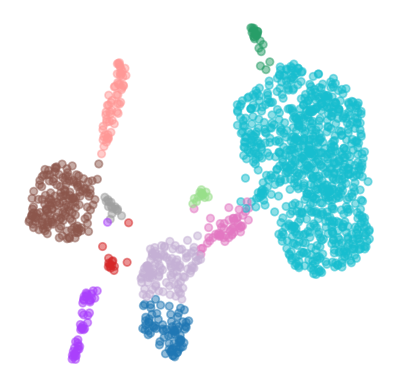

In [47]:
name2color = {'Posterior Roof Plate':"#1f77b4",
 'Low Quality Cells':'#9f9f9f',
 'RetProg': '#279e68',
 'Hox-rich organizer':'#d62728',
 'Mesenchyme':'#aa40fc',
 'Schwann cell precursors':'#8c564b',
 'Mesencephalon (Midbrain)': '#e377c2',
 'Prosencephalon (Forebrain)': '#17becf',
 'Neuroblasts 2': '#98df8a',
 'Neuroblasts 1':'#ff9896',
 'Rhombencephalon (Hindbrain)': '#c5b0d5'}

adata2 = adata.copy()#[adata.obs["cell_type"]!="Low Quality Cells"].copy()
em = adata2.obsm["X_umap"]
plt.scatter(em[:, 0], em[:, 1], s=20, alpha=0.5, c=[name2color[i] for i in adata2.obs["cell_type"]], rasterized=False)
plt.axis("off")
plt.show()

In [48]:
adata_raw_norm.obs["cell_type"].value_counts()/len(adata_raw_norm)*100

Prosencephalon (Forebrain)     58.538350
Schwann cell precursors        12.083936
Rhombencephalon (Hindbrain)     7.814761
Posterior Roof Plate            5.716353
Neuroblasts 1                   4.196816
Mesencephalon (Midbrain)        3.617945
Mesenchyme                      3.400868
RetProg                         1.591896
Low Quality Cells               1.085384
Hox-rich organizer              1.013025
Neuroblasts 2                   0.940666
Name: cell_type, dtype: float64

In [49]:
edf.head(15)

,Posterior Roof Plate,RetProg,Neuroblasts 2,Hox-rich organizer,Mesenchyme,LowQualityCells,Mesencephalon (Midbrain),Schwann cell precursors,Prosencephalon (Forebrain),Neuroblasts 1,Rhombencephalon (Hindbrain)
0,SOST,DCT,UNCX,HOXA-AS3,PITX1,MIXL1,EN1,ITGA4,BARHL1,SIX1,OLIG3
1,RIPPLY3,TYRP1,CCNO,HOXB-AS3,HAND1,MSGN1,WNT1,ABCC2,C1orf61,TNNC2,FGF17
2,CXCL13,ANXA1,LINC00599,HOXA7,DCN,AC090679.2,PAX8,MPZ,CLDN1,SST,ANO3
3,IFIT1,GPNMB,CDC20B,HOXB9,PITX2,LGALS7B,GRM1,SOX10,EMX2,NEUROD1,CYP26C1
4,MAFB,MITF,INSM1,HOXA3,HAND2,LINC00458,GRIA1,EDNRA,MECOM,POU4F1,EN2
5,ADCY2,WFDC1,EBF3,URAD,H19,UFSP1,WNT10B,MOXD1,PAX6,ISL1,DACH2
6,WSCD2,SLC35D3,TMEM176B,CDX2,COL3A1,KCNK2,ASCL1,PRSS56,ARX,SNCG,NKX2-5
7,FAM181B,CCL2,SLC17A6,NKX1-2,C5orf66-AS1,AC105446.1,RPRML,SCRG1,DRD4,PPP1R17,AL359091.1
8,TMEM163,PMEL,LHX9,HOXA9,LUM,ABLIM2,NTRK2,PHACTR3,EMX2OS,EYA2,FOXQ1
9,SERTM1,TRPM1,EOMES,HOXB3,MYL7,RNASE6,DIO3,COL11A2,DMRT3,NHLH1,SNTG1


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


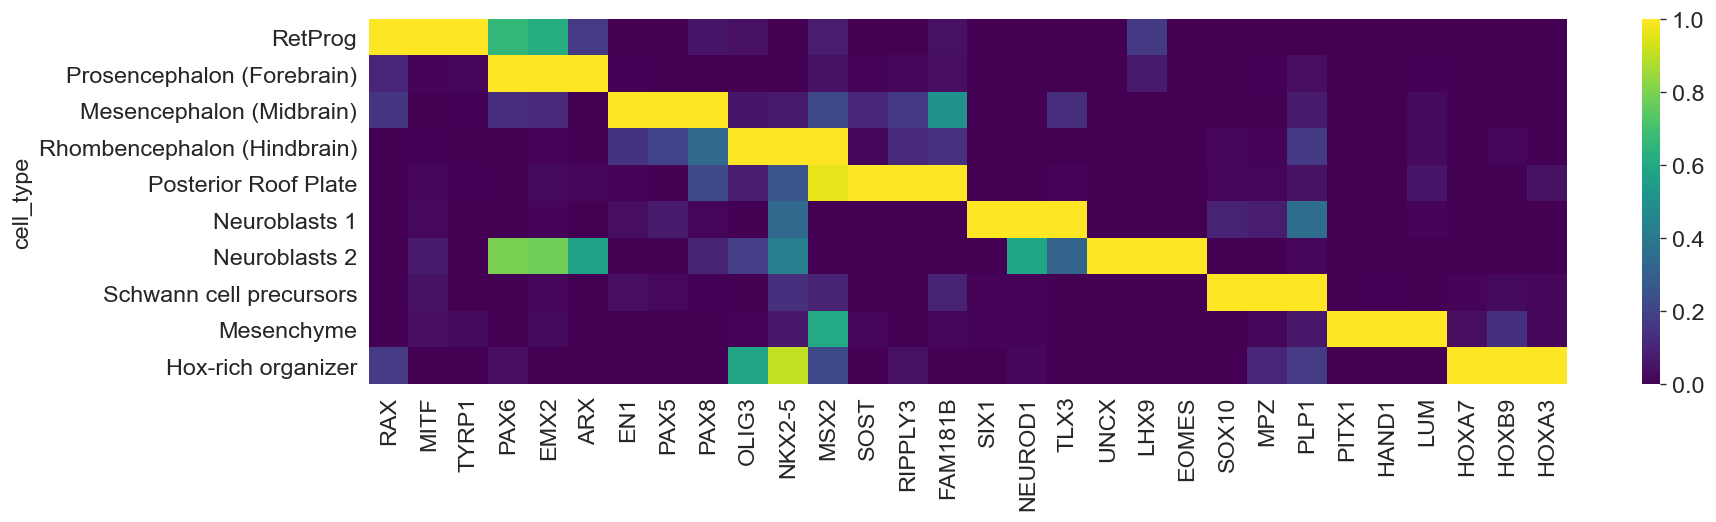

In [50]:
genes = ["RAX", "MITF", "TYRP1",
        "PAX6", "EMX2", "ARX",
        "EN1", "PAX5", "PAX8",
        "OLIG3", "NKX2-5", "MSX2",
        "SOST", "RIPPLY3", "FAM181B",
        "SIX1", "NEUROD1", "TLX3",
         "UNCX", "LHX9", "EOMES",
         "SOX10", "MPZ", "PLP1", 
         "PITX1", "HAND1", "LUM",
        "HOXA7", "HOXB9", "HOXA3"]

X = pd.DataFrame(adata_raw_norm[:, genes].X.toarray())
X.index = adata_raw_norm.obs["cell_type"]
X.columns = genes
X = X.groupby(X.index).mean()

X = X.loc[['RetProg', 'Prosencephalon (Forebrain)',  'Mesencephalon (Midbrain)',
 'Rhombencephalon (Hindbrain)', 'Posterior Roof Plate',
 'Neuroblasts 1',  'Neuroblasts 2',  'Schwann cell precursors',  'Mesenchyme', 'Hox-rich organizer',]]

plt.figure(None, (16, 4))
sns.heatmap((X - X.min()) / (X.max() - X.min()), cmap='viridis')
plt.show()

In [51]:
import signatures
vitro_data = sc.read_h5ad("ALL_VITRO_TIMECOURSE_DATA_RAW.h5ad")
vitro_data_subset = vitro_data[vitro_data.obs["DAY"].isin(["D7", "D14", "D30"])].copy()
all_adatas = adata_raw.concatenate(sc.read_h5ad("EB_D28_Analysis.h5ad"), vitro_data_subset)

In [52]:
sc.pp.normalize_total(all_adatas)
sc.pp.log1p(all_adatas)

In [53]:
forebrain_sig = ["PAX6", "SIX3", "FEZF1", "RAX", "HESX1", "LHX2",
                 "LHX2", "LHX5", "FEZF2", "EMX2", "SHTN1", 
                 "IRS4", "ARX", "OTX1", "OTX2", "DMRT3", 
                 "DMRTA2", "WNT8B", "ZIC4", "SFRP1", "FOXD4",
                "EMX1", "NR2E1", "SIX6", "VAX2"]
midbrain_sig = ["EN1", "EN2", "PAX5", "PAX8", "HES3", 
                "FAM181B", "WNT1", "LMX1A", "LMX1B", "IRX1", 
                "FGF18", "FLRT1", "FGF17", "SOX21", "ASCL1", "TAL2"]
hindbrain_sig = ["HOXB2", "VGLL3", "HOXA2", "HOXB1", "OLIG3",
                 "MSX1", "MSX2", "CASZ1", "FST", "TSHZ1", 
                 "ATP2B4", "UPP1", "CRABP1", "EGR2", "PAX6", 
                 "FZD10", "WNT1"]
progenitor_marker_genes = ["RAX", "OTX2", "ZIC2", "PAX6", "SIX3", "SIX6", "LHX2", "SFRP2", "CRABP1", "VSX2"]
rpe_marker_genes = ['TMEFF2', 'SERPINF1', 'MITF', 'PMEL', 'DCT', 'ELN', 'TYRP1', 'TYR', 'RLBP1', 'BEST1',
                   'RPE65', 'TTR', 'RGR', 'SFRP5', 'SLC6A13']
crnecr_sig = ["FOXC1", "FOXC2", "TFAP2A", "PITX1", "PITX2", 
              "ALX1", "OTX1", "GATA3"]
preplac_sig = ["SIX1", "SIX4", "EYA1", "EYA2", "IRX1", 
               "IRX2", "IRX3", "SOX11", "PAX6", "OTX2", 
               "SIX3", "GATA2", "GATA3"]
latneep_sig = ["DLX5", "DLX6", "SP8", "SP9", "DLK1", 
               "DLX3", "DLX4", "SEMA3E"]

In [54]:
forebrain_zscores = signatures.signature_score(all_adatas.X.T.toarray(), all_adatas.var.index, forebrain_sig)
midbrain_zscores = signatures.signature_score(all_adatas.X.T.toarray(), all_adatas.var.index, midbrain_sig)
hindbrain_zscores = signatures.signature_score(all_adatas.X.T.toarray(), all_adatas.var.index, hindbrain_sig)

progenitor_zscores = signatures.signature_score(all_adatas.X.T.toarray(), all_adatas.var.index, progenitor_marker_genes)
rpe_zscores = signatures.signature_score(all_adatas.X.T.toarray(), all_adatas.var.index, rpe_marker_genes)

crnecr_zscores = signatures.signature_score(all_adatas.X.T.toarray(), all_adatas.var.index, crnecr_sig)
preplac_zscores = signatures.signature_score(all_adatas.X.T.toarray(), all_adatas.var.index, preplac_sig)
latneep_zscores = signatures.signature_score(all_adatas.X.T.toarray(), all_adatas.var.index, latneep_sig)

In [55]:
all_adatas.obs["Forebrain Signature"] = forebrain_zscores
all_adatas.obs["Midbrain Signature"] = midbrain_zscores
all_adatas.obs["Hindbrain Signature"] = hindbrain_zscores
all_adatas.obs["RetProg Signature"] = progenitor_zscores
all_adatas.obs["RPE Signature"] = rpe_zscores
all_adatas.obs["CrNeCr Signature"] = crnecr_zscores
all_adatas.obs["PrePlac Signature"] = preplac_zscores
all_adatas.obs["LatNeEp Signature"] = latneep_zscores

In [56]:
import matplotlib as mpl
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

cmap = 'viridis' 

In [57]:
EB_14_joint_sig = all_adatas[all_adatas.obs["batch"]=="0"].copy()
EB_14_joint_sig.obsm["X_umap"] = adata_raw_norm.obsm["X_umap"]
EB_14_ct = EB_14_joint_sig.obs["cell_type"]
EB_14_forbrain_sig = EB_14_joint_sig.obs["Forebrain Signature"]
EB_14_midbrain_sig = EB_14_joint_sig.obs["Midbrain Signature"]
EB_14_hindbrain_sig = EB_14_joint_sig.obs["Hindbrain Signature"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


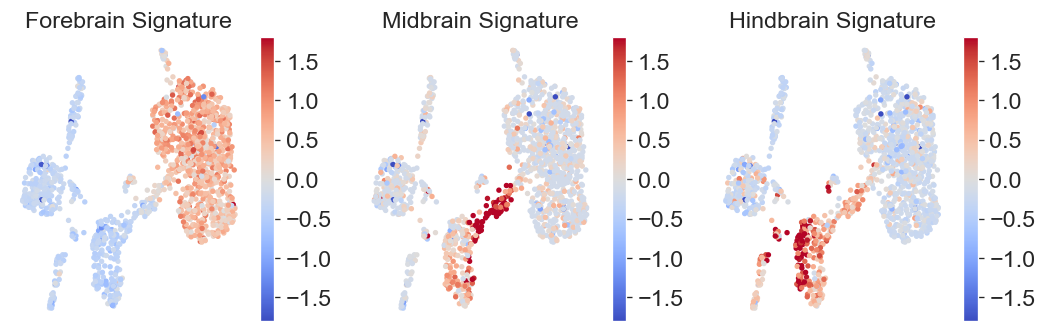

In [58]:
plt.figure(None, (9, 3))
gs = plt.GridSpec(1, 3)
em = EB_14_joint_sig.obsm["X_umap"]

plt.subplot(gs[0,0])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["Forebrain Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["Forebrain Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=EB_14_joint_sig.obs["Forebrain Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("Forebrain Signature")
plt.colorbar()
plt.axis("off")

plt.subplot(gs[0,1])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["Midbrain Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["Midbrain Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=EB_14_joint_sig.obs["Midbrain Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("Midbrain Signature")
plt.colorbar()
plt.axis("off")

plt.subplot(gs[0,2])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["Hindbrain Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["Hindbrain Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=EB_14_joint_sig.obs["Hindbrain Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("Hindbrain Signature")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Passing p

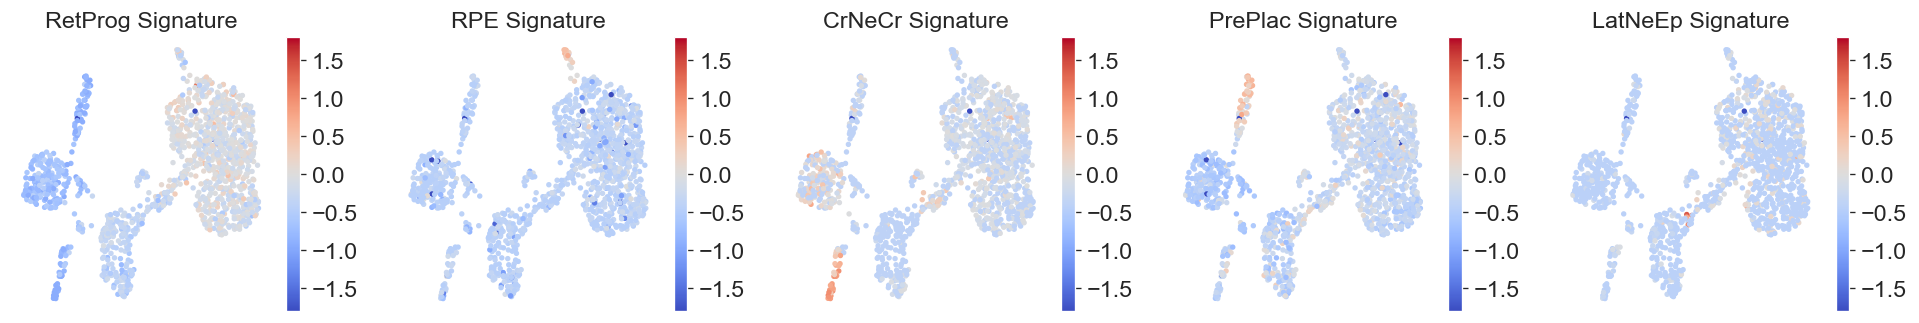

In [59]:
plt.figure(None, (20, 3))
gs = plt.GridSpec(1, 5)
em = EB_14_joint_sig.obsm["X_umap"]

plt.subplot(gs[0,0])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["RetProg Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["RetProg Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=EB_14_joint_sig.obs["RetProg Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("RetProg Signature")
plt.colorbar()
plt.axis("off")

plt.subplot(gs[0,1])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["RPE Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["RPE Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=EB_14_joint_sig.obs["RPE Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("RPE Signature")
plt.colorbar()
plt.axis("off")


plt.subplot(gs[0,2])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["CrNeCr Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["CrNeCr Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=EB_14_joint_sig.obs["CrNeCr Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("CrNeCr Signature")
plt.colorbar()
plt.axis("off")


plt.subplot(gs[0,3])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["PrePlac Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["PrePlac Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=EB_14_joint_sig.obs["PrePlac Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("PrePlac Signature")
plt.colorbar()
plt.axis("off")


plt.subplot(gs[0,4])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["LatNeEp Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["LatNeEp Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=EB_14_joint_sig.obs["LatNeEp Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("LatNeEp Signature")
plt.colorbar()
plt.axis("off")
plt.show()

In [60]:
vitro_subset_sig = all_adatas[all_adatas.obs["batch"]=="2"].copy()

adata7 = vitro_subset_sig[vitro_subset_sig.obs["DAY"]=="D7"].copy()
adata14 = vitro_subset_sig[vitro_subset_sig.obs["DAY"]=="D14"].copy()
adata30 = vitro_subset_sig[vitro_subset_sig.obs["DAY"]=="D30"].copy()

adata7.obsm["X_umap"] = np.stack([adata7.obs["DAY_INTEGRATED_UMAP1"]*-1, adata7.obs["DAY_INTEGRATED_UMAP2"]]).T
adata14.obsm["X_umap"] = np.stack([adata14.obs["DAY_INTEGRATED_UMAP1"]*-1, adata14.obs["DAY_INTEGRATED_UMAP2"]]).T
adata30.obsm["X_umap"] = np.stack([adata30.obs["DAY_INTEGRATED_UMAP1"], adata30.obs["DAY_INTEGRATED_UMAP2"]]).T

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Passing p

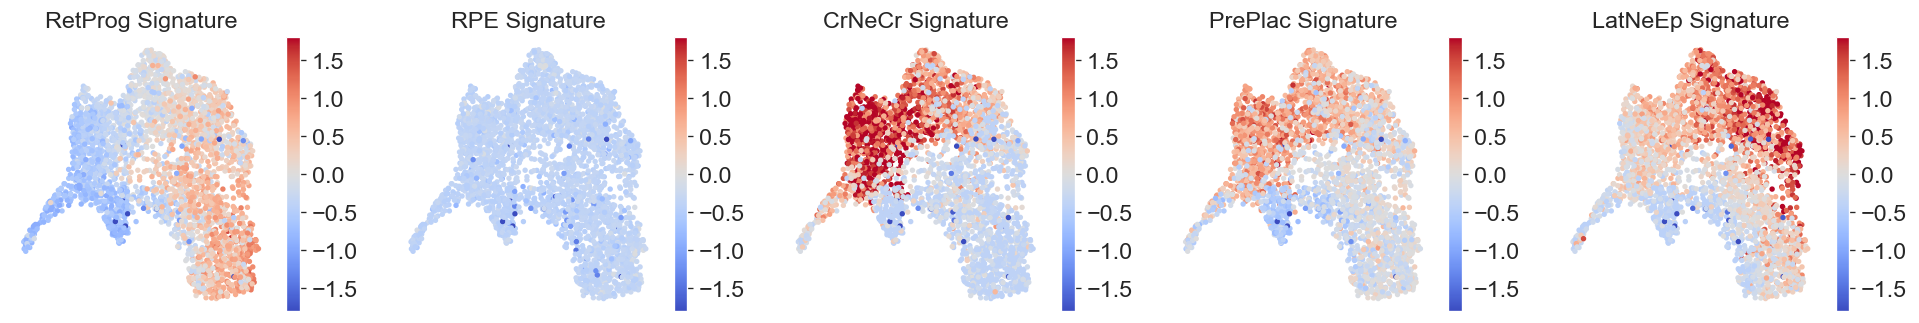

In [61]:
plt.figure(None, (20, 3))
gs = plt.GridSpec(1, 5)
em = adata7.obsm["X_umap"]

plt.subplot(gs[0,0])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["RetProg Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["RetProg Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata7.obs["RetProg Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("RetProg Signature")
plt.colorbar()
plt.axis("off")

plt.subplot(gs[0,1])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["RPE Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["RPE Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata7.obs["RPE Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("RPE Signature")
plt.colorbar()
plt.axis("off")


plt.subplot(gs[0,2])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["CrNeCr Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["CrNeCr Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata7.obs["CrNeCr Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("CrNeCr Signature")
plt.colorbar()
plt.axis("off")


plt.subplot(gs[0,3])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["PrePlac Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["PrePlac Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata7.obs["PrePlac Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("PrePlac Signature")
plt.colorbar()
plt.axis("off")


plt.subplot(gs[0,4])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["LatNeEp Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["LatNeEp Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata7.obs["LatNeEp Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("LatNeEp Signature")
plt.colorbar()
plt.axis("off")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Passing p

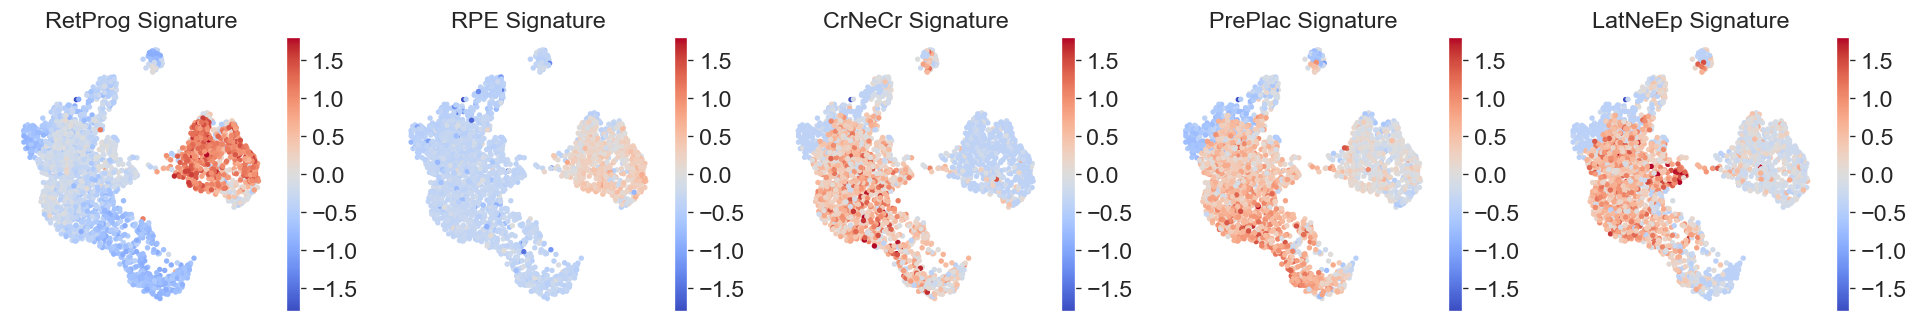

In [62]:
plt.figure(None, (20, 3))
gs = plt.GridSpec(1, 5)
em = adata14.obsm["X_umap"]

plt.subplot(gs[0,0])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["RetProg Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["RetProg Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata14.obs["RetProg Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("RetProg Signature")
plt.colorbar()
plt.axis("off")

plt.subplot(gs[0,1])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["RPE Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["RPE Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata14.obs["RPE Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("RPE Signature")
plt.colorbar()
plt.axis("off")


plt.subplot(gs[0,2])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["CrNeCr Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["CrNeCr Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata14.obs["CrNeCr Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("CrNeCr Signature")
plt.colorbar()
plt.axis("off")


plt.subplot(gs[0,3])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["PrePlac Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["PrePlac Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata14.obs["PrePlac Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("PrePlac Signature")
plt.colorbar()
plt.axis("off")


plt.subplot(gs[0,4])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["LatNeEp Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["LatNeEp Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata14.obs["LatNeEp Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("LatNeEp Signature")
plt.colorbar()
plt.axis("off")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


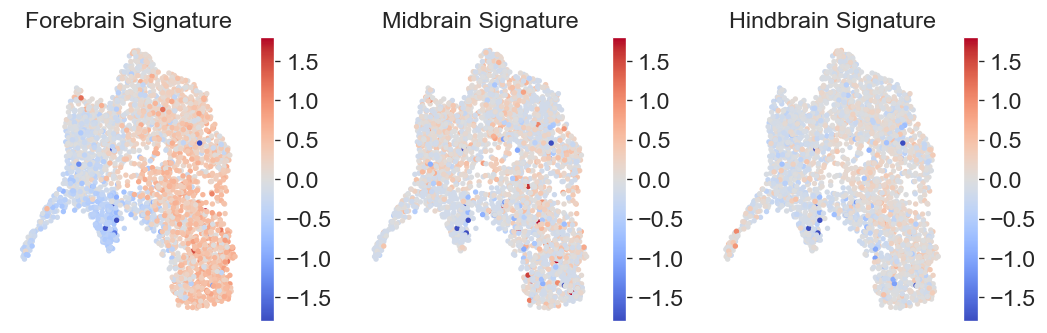

In [63]:
plt.figure(None, (9, 3))
gs = plt.GridSpec(1, 3)
em = adata7.obsm["X_umap"]

plt.subplot(gs[0,0])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["Forebrain Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["Forebrain Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata7.obs["Forebrain Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("Forebrain Signature")
plt.colorbar()
plt.axis("off")

plt.subplot(gs[0,1])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["Midbrain Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["Midbrain Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata7.obs["Midbrain Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("Midbrain Signature")
plt.colorbar()
plt.axis("off")

plt.subplot(gs[0,2])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["Hindbrain Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["Hindbrain Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata7.obs["Hindbrain Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("Hindbrain Signature")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


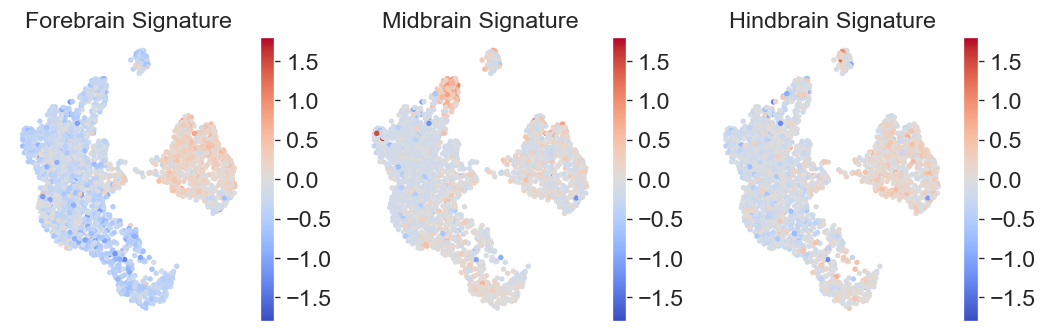

In [64]:
plt.figure(None, (9, 3))
gs = plt.GridSpec(1, 3)
em = adata14.obsm["X_umap"]

plt.subplot(gs[0,0])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["Forebrain Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["Forebrain Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata14.obs["Forebrain Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("Forebrain Signature")
plt.colorbar()
plt.axis("off")

plt.subplot(gs[0,1])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["Midbrain Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["Midbrain Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata14.obs["Midbrain Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("Midbrain Signature")
plt.colorbar()
plt.axis("off")

plt.subplot(gs[0,2])
norm = MidpointNormalize(vmin=np.percentile(all_adatas.obs["Hindbrain Signature"], 0.5), 
                         vmax=np.percentile(all_adatas.obs["Hindbrain Signature"], 99.5), midpoint=0)
plt.scatter(em[:, 0], em[:, 1], s=5, c=adata14.obs["Hindbrain Signature"], cmap='coolwarm', alpha=1, norm=norm,
           vmin=-1.8, vmax=1.8, rasterized=True)
plt.title("Hindbrain Signature")
plt.colorbar()
plt.axis("off")

plt.tight_layout()
plt.show()

In [65]:
adata_raw

AnnData object with n_obs × n_vars = 1382 × 36601
    obs: 'n_counts', 'n_genes', 'percent_mito', 'louvain', 'cell_type'
    var: 'gene_ids', 'feature_types'
    obsm: 'X_umap'